In [1]:
import gym, ray
import os, sys, pickle, time, math
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# ----------
# Line notify
url = "https://notify-api.line.me/api/notify"
token = '88RzP9jGYYEusPQKqpdWpELln97VxOah7ZIab2MyV1R'
headers = {"Authorization" : "Bearer "+ token}

# ----------
# flow
from flow.utils.registry import make_create_env
benchmark_name = 'multi_merge'
benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.buffered_obs_flow_params

# ----------
# PyTorch
import torch
from tensorboardX import SummaryWriter
use_cuda = torch.cuda.is_available()
device   = torch.device("cpu") # "cuda" if use_cuda else "cpu")
print("device: {}".format(device))

# ----------
# my libs
from env.remote_vector_env import MultiAgentVecEnv, dict_to_array
from core.replay_memory import MultiAgentMemory
from core.multi_agent import MultiAgent
from core.ppo import ppo_update
from models.network import Actor, Critic

device: cpu


In [3]:
ray.init(num_cpus=2, include_webui=False, ignore_reinit_error=True)

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-05_00-14-47_6093/logs.
Waiting for redis server at 127.0.0.1:13120 to respond...
Waiting for redis server at 127.0.0.1:39999 to respond...
Starting the Plasma object store with 3.2789331959999997 GB memory using /dev/shm.


{'node_ip_address': '172.17.125.185',
 'object_store_addresses': ['/tmp/ray/session_2019-05-05_00-14-47_6093/sockets/plasma_store'],
 'raylet_socket_names': ['/tmp/ray/session_2019-05-05_00-14-47_6093/sockets/raylet'],
 'redis_address': '172.17.125.185:13120',
 'webui_url': ''}

In [10]:
create_env, env_name = make_create_env(params=flow_params, version=0)
sample_env = create_env()
num_inputs = sample_env.observation_space.shape[0]
num_outputs = sample_env.action_space.shape[0]
env = MultiAgentVecEnv(create_env, num_envs=2, remote_env_batch_wait_ms=0)
num_episode_step = int((sample_env.env_params.horizon \
    - sample_env.env_params.warmup_steps) / sample_env.env_params.sims_per_step)

 Starting SUMO on port 53392


# Train

In [11]:
#Hyper params:
lr = 5e-4
num_train_iter = 10
num_rollouts = 1 
num_steps =  num_episode_step * num_rollouts
mini_batch_size = 128
num_sgd_iter = 30
fcnet_hiddens = [100, 50, 25]
gae_lambda = 1.0

writer = SummaryWriter(log_dir='./result')
policy_net = Actor(num_inputs, num_outputs, fcnet_hiddens, std=0.1).to(device)
value_net = Critic(num_inputs, num_outputs, fcnet_hiddens).to(device)
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
value_optimizer = torch.optim.Adam(value_net.parameters(), lr=lr)
agent = MultiAgent(env, policy_net, value_net, policy_optimizer, value_optimizer, writer)

# Debug

In [6]:
agent.collect_samples(num_steps)

Launching env 0 in remote actor
Launching env 1 in remote actor


{0: defaultdict(list,
             {'flow_1.0': [0.7873870685860848,
               0.7890604425104679,
               0.7935878393135564,
               0.7979793562412955,
               0.773274559691438,
               0.7616799122547456,
               0.7667397971664018,
               0.7709370083217068,
               0.7756222595766181,
               0.7772045999044777,
               0.7812162239318429,
               0.7833047195291586,
               0.7861813085297429,
               0.790487059746862,
               0.7773648176233947,
               0.7949736829894856,
               0.7977918691160796,
               0.8003314161972438,
               0.8046666812750498,
               0.7909091978999567,
               0.7939882144406044,
               0.7953835338787043,
               0.7979663544004963,
               0.8002161989313097,
               0.7857549632323545,
               0.7862877536148806,
               0],
              'flow_1.1': [0.7873870685

In [7]:
# now = datetime.datetime.now()
# now = str(now).replace(':', '-').replace(' ', '-')
# now = now[:now.find('.')]
# result_path = './result/ppo/' + now
# os.makedirs(result_path)
# image_path = result_path + '/reward_history.png'
eval_interval = 5

for num_iter in tqdm(range(num_train_iter)):
    agent.collect_samples(num_steps)
    agent.postprocess()
    actor_loss, critic_loss = ppo_update(agent, num_sgd_iter, mini_batch_size)
    writer.add_scalar('loss/actor_loss', actor_loss, num_iter)
    writer.add_scalar('loss/critic_loss', critic_loss, num_iter)
    writer.add_scalar('num_iter', num_iter)
    
    if num_iter % eval_interval == 0:
        agent.
        writer.add_scalar('')

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Launching env 0 in remote actor
Launching env 1 in remote actor


# Main

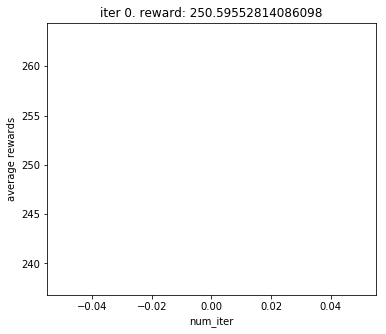

  1%|          | 3/500 [03:42<10:13:55, 74.12s/it]

In [ ]:
# now = datetime.datetime.now()
# now = str(now).replace(':', '-').replace(' ', '-')
# now = now[:now.find('.')]
# result_path = './result/ppo/' + now
# os.makedirs(result_path)
# image_path = result_path + '/reward_history.png'
# 
test_rewards, num_iters = [], []

for num_iter in trange(training_iter):
    agent.collect_samples(num_steps)
    ppo_update(model, optimizer, num_sgd_iter, mini_batch_size, trajectory)

In [ ]:
if num_iter % 25 == 0:
        model_id = ray.put(model)
        results_ids = [ev.test_env.remote(device, model_id) for ev in evs]
        test_reward = np.mean(ray.get(results_ids))
        test_rewards.append(test_reward)
        num_iters.append(num_iter)
        plot_and_save(num_iters, test_rewards, image_path)
        model_path = result_path + '/checkpoint' + str(num_iter) + '.pt'
        torch.save(model.state_dict(), model_path)
        send_line(url, headers, 'epoch: {}'.format(num_iter), image_path)

# Test

In [ ]:
model = ActorCritic(num_inputs, num_outputs, fcnet_hiddens).to(device)

model_path = './result/ppo/2019-04-02-02-06-26/checkpoint475.pt'
model.load_state_dict(torch.load(model_path))
model.eval()
model_id = ray.put(model)

In [ ]:
env = make_vis_env(benchmark_name)

test_env(env, device, model)